# 0. Introduccion

El indice es el siguiente:

- 1. Explorando los datos
- 2. Limpiando y normalizando los datos
- 3. Entrenando el modelo
- 4. Visualizacion de los datos y el modelo resultante

# 1. Explorando los datos

Antes de empezar vamos a cargar los datos del CSV que nos ha tocado.  
Empezaremos con la carga de las librerias necesarias.

In [56]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [57]:
DATA_DIR = 'data/insurance.csv'

def read_database(dir : str):
    return pd.read_csv(dir, delimiter= ',')

df = read_database(DATA_DIR)
print(df.head(5))
print(df.describe())
print(df.info())

   age     sex   bmi  children smoker     region  expenses
0   19  female  27.9         0    yes  southwest  16884.92
1   18    male  33.8         1     no  southeast   1725.55
2   28    male  33.0         3     no  southeast   4449.46
3   33    male  22.7         0     no  northwest  21984.47
4   32    male  28.9         0     no  northwest   3866.86
               age          bmi     children      expenses
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.665471     1.094918  13270.422414
std      14.049960     6.098382     1.205493  12110.011240
min      18.000000    16.000000     0.000000   1121.870000
25%      27.000000    26.300000     0.000000   4740.287500
50%      39.000000    30.400000     1.000000   9382.030000
75%      51.000000    34.700000     2.000000  16639.915000
max      64.000000    53.100000     5.000000  63770.430000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Colu

Podemos ver que tenemos 2 columnas decimales que es el bmi y los costes. 2 columnas con valores enteros, age y children. Por ultimo tenemos 3 columnas categoricas smoker, region, sex.

Sabiendo esta informacion vamos a ver la cantidad de gente fumadora.

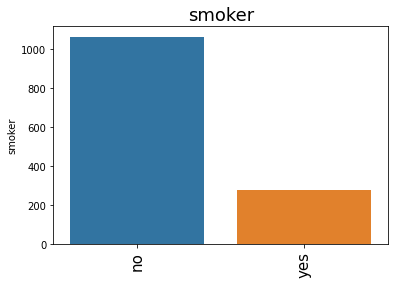

In [58]:
def barplot_gen(df_colum : pd.Series):
    classes = df_colum.value_counts()
    class_len = len(classes)
    sns.barplot(x=np.arange(class_len), y=classes)
    plt.xticks(np.arange(len(classes)), classes.index.values.tolist(), rotation=90, fontsize=15)
    plt.title(df_colum.name, fontsize=18)
    plt.show()

barplot_gen(df['smoker'])

Podemos observar que la cantidad de fumadores en esta base de datos es muy baja, por lo que si queremos realizar una prediccion de esta atributo tendremos problemas para poder realizar un entrenamiento del modelo de red neuronal. Al tratarse en esta practica de utilizar un modelos de regresion lineal y ser valores categoricos, vamos a descartar este valor para realizar la prediccion.

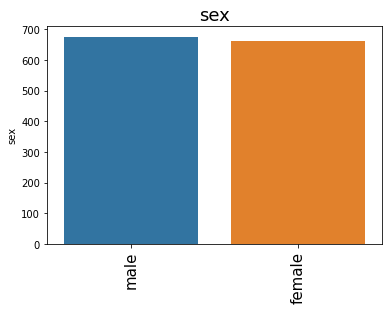

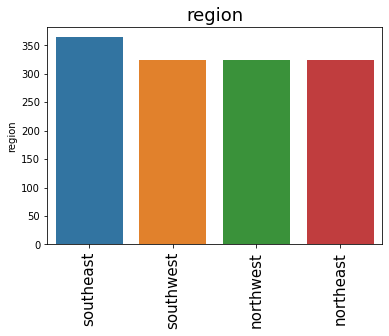

In [59]:
barplot_gen(df['sex'])
barplot_gen(df['region'])

Una vez visto los valores categoricos podemos descartar smoker como a valor a predecir, ya que tenemos pocos datos de valores de fumadores. Pero en cambio si queremos hacer una regresion logistica podemos utilizar sex.

Ahora vamos a ver los valores no categoricos.

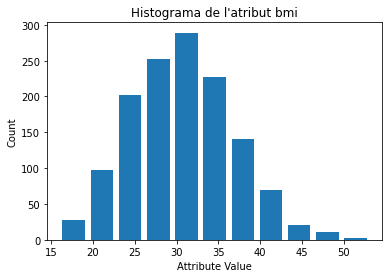

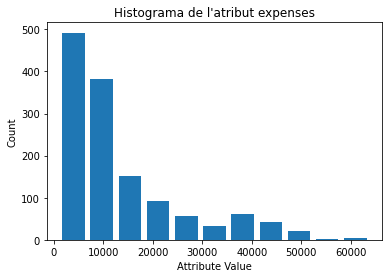

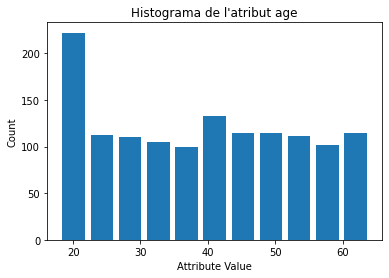

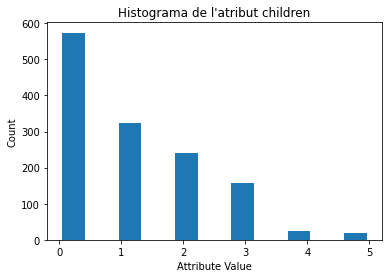

In [60]:
def hist_gen(df_colum : pd.Series):
    plt.figure()
    plt.title(f"Histograma de l'atribut {df_colum.name}")
    plt.xlabel("Attribute Value")
    plt.ylabel("Count")
    plt.hist(df_colum, bins=11, range=[np.min(df_colum), np.max(df_colum)], histtype="bar", rwidth=0.8)

hist_gen(df['bmi'])
hist_gen(df['expenses'])
hist_gen(df['age'])
hist_gen(df['children'])

Podemos observar que hay un atributo que si tiene una distribucion Guassiana, en este caso es el atributo bmi.

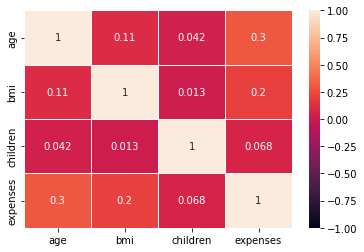

In [64]:
correlacio = df.corr()
plt.figure()
ax = sns.heatmap(correlacio, annot=True, vmin=-1, linewidths=.5)

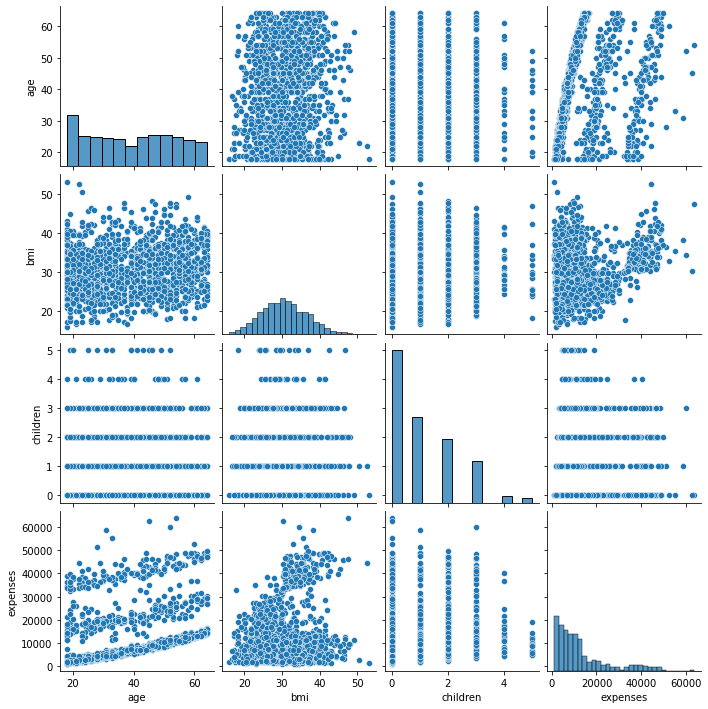

In [65]:
relacio = sns.pairplot(df)